In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from tqdm import tqdm

In [31]:
from matplotlib import font_manager, rc
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

> qgis를 이용하여 그리드와 버퍼를 count를 할 경우 유의미한 정보들(버스의 총하차수 등)이 손실됨  
따라서, qgis를 통해 만든 grid, buffer 레이어를 파이썬 geopandas의 sjoin을 이용하여 결합하고자 함


# 파일 불러오기

In [32]:
seoul = gpd.read_file('shp/서울/서울시_grid_100M_5179.shp').set_index('unique_id', drop=True).drop('id', axis=1)
bs = gpd.read_file('shp/버퍼/BS_buffer.shp', encoding='cp949').drop(['field_1', 'Unnamed_ 0'], axis=1)
cs = gpd.read_file('shp/버퍼/CS_buffer.shp', encoding='cp949')
ss = gpd.read_file('shp/버퍼/SS_buffer.shp', encoding='cp949')

In [33]:
print(seoul.shape)
seoul.head()

(61634, 5)


,left,top,right,bottom,geometry
unique_id,,,,,
1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1..."
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1..."
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1..."
4,957035.2302,1.948287e+06,957135.2302,1.948187e+06,"POLYGON ((957035.230 1948287.158, 957135.230 1..."
5,957035.2302,1.948387e+06,957135.2302,1.948287e+06,"POLYGON ((957035.230 1948387.158, 957135.230 1..."


In [34]:
print(bs.shape)
bs.head()

(10564, 6)


,표준ID,정류소명,X좌표,Y좌표,총승하차승,geometry
0,100000001,종로2가사거리,126.9877861534,37.5697641508,30862,"POLYGON ((955267.380 1952389.467, 955265.838 1..."
1,100000002,창경궁.서울대학교병원,126.9965201597,37.5791788583,141539,"POLYGON ((956044.265 1953429.815, 956042.724 1..."
2,100000003,명륜3가.성대입구,126.9982901625,37.582708818899995,189258,"POLYGON ((956202.644 1953820.611, 956201.102 1..."
3,100000004,종로2가.삼일교,126.9875072018,37.5685822333,46309,"POLYGON ((955242.031 1952258.473, 955240.489 1..."
4,100000005,혜화동로터리.여운형활동터,127.00169434940001,37.5862299819,130017,"POLYGON ((956505.283 1954209.668, 956503.742 1..."


In [35]:
print(cs.shape)
cs.head()

(2912, 2)


,address,geometry
0,"37 Maebongsan-ro, Sangam-dong, Mapo-gu, Seoul,...","POLYGON ((946683.434 1953133.599, 946681.893 1..."
1,"South Korea, Seoul, Mapo-gu, Sangam-dong, Maeb...","POLYGON ((947001.898 1953408.826, 947000.357 1..."
2,"3104 Nambusunhwan-ro, Daechi-dong, Gangnam-gu,...","POLYGON ((962688.014 1944151.385, 962686.472 1..."
3,"621 Gaepo-ro, Gaepo-dong, Gangnam-gu, Seoul, S...","POLYGON ((963266.224 1943960.425, 963264.683 1..."
4,"932 Yangjae-daero, Garak 1(il)-dong, Songpa-gu...","POLYGON ((966230.197 1943819.626, 966228.655 1..."


In [36]:
print(ss.shape)
ss.head()

(384, 6)


,line,name,code,lat,lng,geometry
0,01호선,남영,1002,37.541021,126.9713,"POLYGON ((953793.572 1949208.624, 953792.031 1..."
1,01호선,용산,1003,37.529849,126.964561,"POLYGON ((953191.173 1947972.520, 953189.632 1..."
2,01호선,노량진,1004,37.514219,126.942454,"POLYGON ((951227.611 1946249.808, 951226.070 1..."
3,01호선,대방,1005,37.513342,126.926382,"POLYGON ((949806.664 1946161.049, 949805.123 1..."
4,01호선,영등포,1006,37.515504,126.907628,"POLYGON ((948150.779 1946411.180, 948149.238 1..."


# Counting

### BS_count

In [37]:
bs_join = gpd.sjoin(seoul, bs, how='left', op = 'within')
bs_df = pd.DataFrame(bs_join).drop('geometry', axis=1)
bs_final = bs_df.drop(['index_right', '정류소명', 'X좌표', 'Y좌표'], axis=1)
bs_final['총승하차승'] = bs_final['총승하차승'].astype(float)
bs_group = bs_final.groupby([bs_final.index, 'left', 'top', 'right', 'bottom'], as_index=False).agg({'표준ID':'count', '총승하차승':'sum'})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


### SS_count

In [38]:
ss_join = gpd.sjoin(seoul, ss, how='left', op = 'within')
ss_df = pd.DataFrame(ss_join).drop('geometry', axis=1)
ss_final = ss_df.drop(['index_right', 'line', 'name', 'lat', 'lng'], axis=1)
ss_group = ss_final.groupby([ss_final.index, 'left', 'top', 'right', 'bottom'], as_index=False).count()
ss_group

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,left,top,right,bottom,code
0,957035.2302,1.947987e+06,957135.2302,1.947887e+06,0
1,957035.2302,1.948087e+06,957135.2302,1.947987e+06,0
2,957035.2302,1.948187e+06,957135.2302,1.948087e+06,0
3,957035.2302,1.948287e+06,957135.2302,1.948187e+06,0
4,957035.2302,1.948387e+06,957135.2302,1.948287e+06,0
...,...,...,...,...,...
61629,957035.2302,1.953887e+06,957135.2302,1.953787e+06,1
61630,957035.2302,1.953987e+06,957135.2302,1.953887e+06,0
61631,957035.2302,1.954087e+06,957135.2302,1.953987e+06,0
61632,957035.2302,1.954187e+06,957135.2302,1.954087e+06,0


In [39]:
bs_group['표준ID'].value_counts()

0     12909
12     2452
2      2427
10     2404
13     2356
8      2309
14     2294
4      2284
6      2282
11     2275
9      2233
15     2123
16     2033
7      1985
5      1901
17     1855
18     1722
3      1640
19     1505
1      1371
20     1338
21     1241
22     1071
23      858
24      842
25      695
26      542
27      467
28      385
29      311
30      261
31      224
33      178
32      172
34      135
35      105
36       85
37       79
38       49
39       45
40       34
42       31
41       30
44       25
43       15
48       12
47       10
45       10
46       10
51        5
49        5
52        2
50        1
53        1
Name: 표준ID, dtype: int64

In [40]:
ss_group['code'].value_counts()

0    45269
1    11491
2     3882
3      627
4      317
5       44
6        2
7        2
Name: code, dtype: int64

### CS_count

In [41]:
cs_join = gpd.sjoin(seoul, cs, how='left', op = 'within')
cs_df = pd.DataFrame(cs_join).drop('geometry', axis=1)
cs_final = cs_df.drop(['index_right'], axis=1)
cs_group = cs_final.groupby([cs_final.index, 'left', 'top', 'right', 'bottom'], as_index=False).count()
cs_group

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,left,top,right,bottom,address
0,957035.2302,1.947987e+06,957135.2302,1.947887e+06,1
1,957035.2302,1.948087e+06,957135.2302,1.947987e+06,1
2,957035.2302,1.948187e+06,957135.2302,1.948087e+06,1
3,957035.2302,1.948287e+06,957135.2302,1.948187e+06,1
4,957035.2302,1.948387e+06,957135.2302,1.948287e+06,1
...,...,...,...,...,...
61629,957035.2302,1.953887e+06,957135.2302,1.953787e+06,13
61630,957035.2302,1.953987e+06,957135.2302,1.953887e+06,12
61631,957035.2302,1.954087e+06,957135.2302,1.953987e+06,8
61632,957035.2302,1.954187e+06,957135.2302,1.954087e+06,4


<AxesSubplot:xlabel='address'>

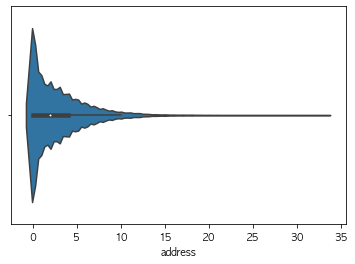

In [42]:
sns.violinplot(data = cs_group, x='address')

seoul에 카운팅한 데이터 추가하기

In [43]:
bs_group.columns, ss_group.columns, cs_group.columns

(Index(['left', 'top', 'right', 'bottom', '표준ID', '총승하차승'], dtype='object'),
 Index(['left', 'top', 'right', 'bottom', 'code'], dtype='object'),
 Index(['left', 'top', 'right', 'bottom', 'address'], dtype='object'))

In [44]:
seoul[['bs_count', 'bs_승하차수']] = bs_group[['표준ID', '총승하차승']]
seoul['ss_count'] = ss_group['code']
seoul['cs_count'] = cs_group['address']

seoul.head()

,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,,,,,
1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,957035.2302,1.948287e+06,957135.2302,1.948187e+06,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
5,957035.2302,1.948387e+06,957135.2302,1.948287e+06,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0


In [45]:
seoul

,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,,,,,
1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,957035.2302,1.948287e+06,957135.2302,1.948187e+06,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
5,957035.2302,1.948387e+06,957135.2302,1.948287e+06,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
61630,957035.2302,1.953887e+06,957135.2302,1.953787e+06,"POLYGON ((957035.230 1953887.158, 957135.230 1...",21.0,192481.0,0.0,12.0
61631,957035.2302,1.953987e+06,957135.2302,1.953887e+06,"POLYGON ((957035.230 1953987.158, 957135.230 1...",18.0,166896.0,0.0,8.0
61632,957035.2302,1.954087e+06,957135.2302,1.953987e+06,"POLYGON ((957035.230 1954087.158, 957135.230 1...",19.0,247239.0,0.0,4.0


In [46]:
seoul.isna().sum()

left        0
top         0
right       0
bottom      0
geometry    0
bs_count    1
bs_승하차수     1
ss_count    1
cs_count    1
dtype: int64

In [47]:
seoul = seoul.dropna()
seoul.head()

,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,,,,,
1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,957035.2302,1.948287e+06,957135.2302,1.948187e+06,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
5,957035.2302,1.948387e+06,957135.2302,1.948287e+06,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0


In [48]:
seoul_nongrid = gpd.read_file('shp/LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11.shp', encoding='cp949')

In [49]:
seoul_nongrid = seoul_nongrid[['EMD_NM','geometry']]

In [50]:
seoul_nongrid.head()

,EMD_NM,geometry
0,연남동,"POLYGON ((948463.577 1952085.035, 948483.560 1..."
1,동교동,"MULTIPOLYGON (((948665.278 1951067.358, 948676..."
2,동소문동1가,"POLYGON ((956316.467 1954570.243, 956321.222 1..."
3,안암동3가,"POLYGON ((958047.781 1954203.838, 958038.530 1..."
4,상도1동,"POLYGON ((951048.818 1945025.905, 951059.497 1..."


In [51]:
seoul_nongrid.shape

(468, 2)

In [52]:
seoul.shape
#61668

(61633, 9)

In [69]:
f_df = gpd.sjoin(seoul, seoul_nongrid, how='left', op = 'intersects')
f_df

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count,index_right,EMD_NM
unique_id,,,,,,,,,,,
1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0,164,압구정동
2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0,416,한남동
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0,416,한남동
...,...,...,...,...,...,...,...,...,...,...,...
61630,957035.2302,1.953887e+06,957135.2302,1.953787e+06,"POLYGON ((957035.230 1953887.158, 957135.230 1...",21.0,192481.0,0.0,12.0,287,삼선동2가
61631,957035.2302,1.953987e+06,957135.2302,1.953887e+06,"POLYGON ((957035.230 1953987.158, 957135.230 1...",18.0,166896.0,0.0,8.0,287,삼선동2가
61632,957035.2302,1.954087e+06,957135.2302,1.953987e+06,"POLYGON ((957035.230 1954087.158, 957135.230 1...",19.0,247239.0,0.0,4.0,287,삼선동2가


In [71]:
f_df.reset_index(inplace=True)
f_df

,index,unique_id,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count,index_right,EMD_NM
0,0,1,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
1,1,2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0,164,압구정동
2,2,2,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0,416,한남동
3,3,3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
4,4,3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0,416,한남동
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73920,73920,61630,957035.2302,1.953887e+06,957135.2302,1.953787e+06,"POLYGON ((957035.230 1953887.158, 957135.230 1...",21.0,192481.0,0.0,12.0,287,삼선동2가
73921,73921,61631,957035.2302,1.953987e+06,957135.2302,1.953887e+06,"POLYGON ((957035.230 1953987.158, 957135.230 1...",18.0,166896.0,0.0,8.0,287,삼선동2가
73922,73922,61632,957035.2302,1.954087e+06,957135.2302,1.953987e+06,"POLYGON ((957035.230 1954087.158, 957135.230 1...",19.0,247239.0,0.0,4.0,287,삼선동2가
73923,73923,61632,957035.2302,1.954087e+06,957135.2302,1.953987e+06,"POLYGON ((957035.230 1954087.158, 957135.230 1...",19.0,247239.0,0.0,4.0,17,삼선동3가


In [72]:
f_df['unique_id'].duplicated().sum()

12292

In [73]:
f_df = f_df.drop_duplicates(subset='unique_id',keep='first').set_index('unique_id', drop=True)
f_df

,index,left,top,right,bottom,geometry,bs_count,bs_승하차수,ss_count,cs_count,index_right,EMD_NM
unique_id,,,,,,,,,,,,
1,0,957035.2302,1.947987e+06,957135.2302,1.947887e+06,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
2,1,957035.2302,1.948087e+06,957135.2302,1.947987e+06,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0,164,압구정동
3,3,957035.2302,1.948187e+06,957135.2302,1.948087e+06,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
4,5,957035.2302,1.948287e+06,957135.2302,1.948187e+06,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0,164,압구정동
5,7,957035.2302,1.948387e+06,957135.2302,1.948287e+06,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0,416,한남동
...,...,...,...,...,...,...,...,...,...,...,...,...
61629,73918,957035.2302,1.953787e+06,957135.2302,1.953687e+06,"POLYGON ((957035.230 1953787.158, 957135.230 1...",21.0,195473.0,1.0,13.0,287,삼선동2가
61630,73920,957035.2302,1.953887e+06,957135.2302,1.953787e+06,"POLYGON ((957035.230 1953887.158, 957135.230 1...",21.0,192481.0,0.0,12.0,287,삼선동2가
61631,73921,957035.2302,1.953987e+06,957135.2302,1.953887e+06,"POLYGON ((957035.230 1953987.158, 957135.230 1...",18.0,166896.0,0.0,8.0,287,삼선동2가


In [74]:
f_df_압구정 = f_df[sample['EMD_NM']=='압구정동']

# Model Training_binary classification

In [88]:
binary = f_df.copy()

In [89]:
binary.columns

Index(['index', 'left', 'top', 'right', 'bottom', 'geometry', 'bs_count',
       'bs_승하차수', 'ss_count', 'cs_count', 'index_right', 'EMD_NM'],
      dtype='object')

In [90]:
binary = binary[['geometry','bs_count', 'bs_승하차수', 'ss_count', 'cs_count']]
binary.head()

,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,
1,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
5,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0


In [91]:
binary['cs_count'].describe()

count    61633.000000
mean         2.799182
std          3.411932
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         33.000000
Name: cs_count, dtype: float64

In [92]:
binary['cs_count'].value_counts()

0.0     20290
1.0      8483
2.0      7458
3.0      6356
4.0      4949
5.0      3689
6.0      2810
7.0      2051
8.0      1494
9.0      1060
10.0      760
11.0      596
12.0      458
13.0      276
14.0      179
15.0      153
16.0      103
17.0       93
18.0       88
19.0       62
20.0       55
21.0       47
22.0       43
23.0       22
26.0       17
27.0       12
25.0       10
24.0        8
28.0        5
30.0        2
32.0        2
29.0        1
33.0        1
Name: cs_count, dtype: int64

In [93]:
binary['label'] = 0
binary.loc[binary['cs_count']>=2,'label'] = 1

In [94]:
binary['label'].value_counts()

1    32860
0    28773
Name: label, dtype: int64

## Geometry polygon to point

In [95]:
binary_label = binary.label.copy()
binary.drop('label', axis=1, inplace=True)

In [98]:
binary.head()

,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,
1,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
5,"POLYGON ((957035.230 1948387.158, 957135.230 1...",1.0,18615.0,0.0,1.0


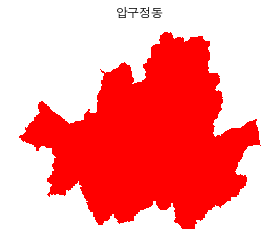

In [96]:
ax = binary['geometry'].plot(color='red')
ax.set_axis_off()
ax.set_title("압구정동")
plt.show()

In [99]:
# change geometry 
binary['geometry'] = binary['geometry'].centroid
binary.head()

,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,
1,POINT (957085.230 1947937.158),0.0,0.0,0.0,1.0
2,POINT (957085.230 1948037.158),1.0,159638.0,0.0,1.0
3,POINT (957085.230 1948137.158),0.0,0.0,0.0,1.0
4,POINT (957085.230 1948237.158),0.0,0.0,0.0,1.0
5,POINT (957085.230 1948337.158),1.0,18615.0,0.0,1.0


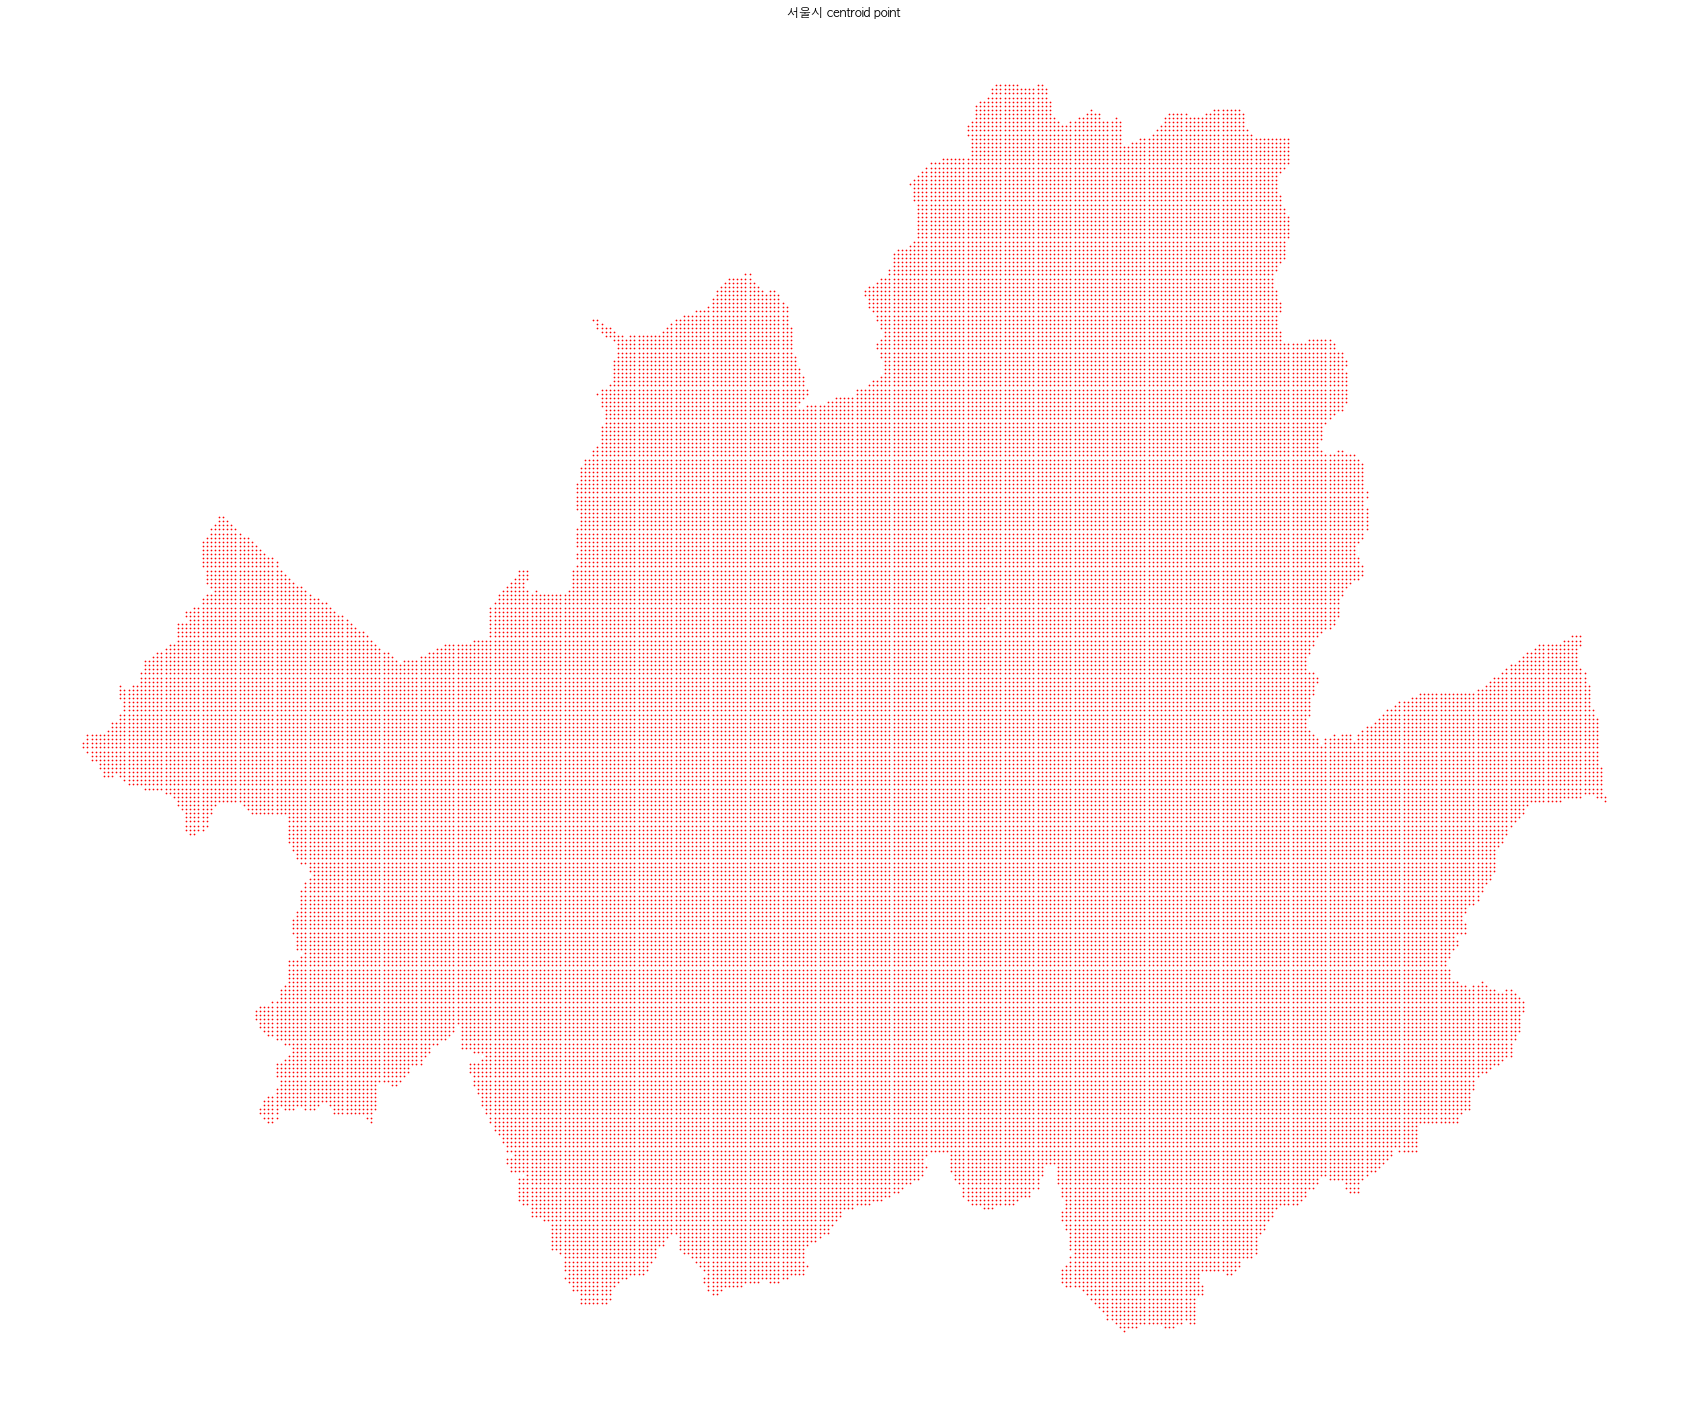

In [108]:
ax = binary['geometry'].plot(marker='o', color='red', markersize=0.5, figsize=(30,30))
ax.set_axis_off()
ax.set_title("서울시 centroid point")
plt.show()

In [109]:
binary.drop(['geometry'], axis=1, inplace=True)

In [110]:
binary

,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,
1,0.0,0.0,0.0,1.0
2,1.0,159638.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
5,1.0,18615.0,0.0,1.0
...,...,...,...,...
61629,21.0,195473.0,1.0,13.0
61630,21.0,192481.0,0.0,12.0
61631,18.0,166896.0,0.0,8.0


## Feature Scaling

In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(binary)
standadized_df = pd.DataFrame(normalized_data)
binary = pd.DataFrame(standadized_df.values, columns=binary.columns)
binary

,bs_count,bs_승하차수,ss_count,cs_count
0,0.000000,0.000000,0.000000,0.030303
1,0.018868,0.053427,0.000000,0.030303
2,0.000000,0.000000,0.000000,0.030303
3,0.000000,0.000000,0.000000,0.030303
4,0.018868,0.006230,0.000000,0.030303
...,...,...,...,...
61628,0.396226,0.065420,0.142857,0.393939
61629,0.396226,0.064418,0.000000,0.363636
61630,0.339623,0.055856,0.000000,0.242424
61631,0.358491,0.082745,0.000000,0.121212


In [112]:
binary

,bs_count,bs_승하차수,ss_count,cs_count
0,0.000000,0.000000,0.000000,0.030303
1,0.018868,0.053427,0.000000,0.030303
2,0.000000,0.000000,0.000000,0.030303
3,0.000000,0.000000,0.000000,0.030303
4,0.018868,0.006230,0.000000,0.030303
...,...,...,...,...
61628,0.396226,0.065420,0.142857,0.393939
61629,0.396226,0.064418,0.000000,0.363636
61630,0.339623,0.055856,0.000000,0.242424
61631,0.358491,0.082745,0.000000,0.121212


In [113]:
binary_label.values

array([0, 0, 0, ..., 1, 1, 1])

In [114]:
binary['label'] = binary_label.values
binary

,bs_count,bs_승하차수,ss_count,cs_count,label
0,0.000000,0.000000,0.000000,0.030303,0
1,0.018868,0.053427,0.000000,0.030303,0
2,0.000000,0.000000,0.000000,0.030303,0
3,0.000000,0.000000,0.000000,0.030303,0
4,0.018868,0.006230,0.000000,0.030303,0
...,...,...,...,...,...
61628,0.396226,0.065420,0.142857,0.393939,1
61629,0.396226,0.064418,0.000000,0.363636,1
61630,0.339623,0.055856,0.000000,0.242424,1
61631,0.358491,0.082745,0.000000,0.121212,1


# Modeling

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
binary

,bs_count,bs_승하차수,ss_count,cs_count,label
0,0.000000,0.000000,0.000000,0.030303,0
1,0.018868,0.053427,0.000000,0.030303,0
2,0.000000,0.000000,0.000000,0.030303,0
3,0.000000,0.000000,0.000000,0.030303,0
4,0.018868,0.006230,0.000000,0.030303,0
...,...,...,...,...,...
61628,0.396226,0.065420,0.142857,0.393939,1
61629,0.396226,0.064418,0.000000,0.363636,1
61630,0.339623,0.055856,0.000000,0.242424,1
61631,0.358491,0.082745,0.000000,0.121212,1


In [117]:
X = binary.drop(['cs_count', 'label'], axis=1)
y = binary['label']

In [118]:
X

,bs_count,bs_승하차수,ss_count
0,0.000000,0.000000,0.000000
1,0.018868,0.053427,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.018868,0.006230,0.000000
...,...,...,...
61628,0.396226,0.065420,0.142857
61629,0.396226,0.064418,0.000000
61630,0.339623,0.055856,0.000000
61631,0.358491,0.082745,0.000000


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
y_train

60106    1
47756    0
1850     0
5625     1
33965    0
        ..
54343    0
38158    1
860      1
15795    0
56422    0
Name: label, Length: 49306, dtype: int64

## RandomForestClassifier

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
binary

,bs_count,bs_승하차수,ss_count,cs_count,label
0,0.000000,0.000000,0.000000,0.030303,0
1,0.018868,0.053427,0.000000,0.030303,0
2,0.000000,0.000000,0.000000,0.030303,0
3,0.000000,0.000000,0.000000,0.030303,0
4,0.018868,0.006230,0.000000,0.030303,0
...,...,...,...,...,...
61628,0.396226,0.065420,0.142857,0.393939,1
61629,0.396226,0.064418,0.000000,0.363636,1
61630,0.339623,0.055856,0.000000,0.242424,1
61631,0.358491,0.082745,0.000000,0.121212,1


In [123]:
X = binary.drop(['ss_count','cs_count', 'label'], axis=1)
y = binary['label']

In [124]:
X

,bs_count,bs_승하차수
0,0.000000,0.000000
1,0.018868,0.053427
2,0.000000,0.000000
3,0.000000,0.000000
4,0.018868,0.006230
...,...,...
61628,0.396226,0.065420
61629,0.396226,0.064418
61630,0.339623,0.055856
61631,0.358491,0.082745


In [125]:
y

0        0
1        0
2        0
3        0
4        0
        ..
61628    1
61629    1
61630    1
61631    1
61632    1
Name: label, Length: 61633, dtype: int64

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
len(X_test)

12327

In [128]:
y_test

43045    1
28843    1
39025    1
4981     0
31596    0
        ..
817      1
25975    1
16397    1
53374    0
34405    1
Name: label, Length: 12327, dtype: int64

In [129]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [130]:
rf.score(X_train, y_train)

0.9775483713949621

I guess this model is overfitted.  
We should do cross validation test.

In [131]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

y_train_pred = cross_val_predict(rf, X_train, y_train, cv=3)

In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[17460,  5441],
       [ 5961, 20444]])

In [133]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)

(0.7898010430751401, 0.7742473016474153)

In [134]:
y_pred = rf.predict(X_test)

In [135]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7783169664434346

In [136]:
y_score = cross_val_predict(rf, X_train, y_train, cv=3)
y_score

array([1, 0, 1, ..., 1, 0, 0])

In [137]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)

In [138]:
precisions, recalls

(array([0.5355332 , 0.78907845, 1.        ]),
 array([1.       , 0.7759894, 0.       ]))

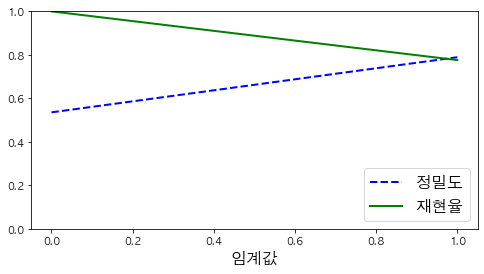

In [147]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="lower right", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [148]:
y_pred = rf.predict_proba(X_test)
y_pred

array([[0.01      , 0.99      ],
       [0.04      , 0.96      ],
       [0.02      , 0.98      ],
       ...,
       [0.        , 1.        ],
       [0.95394336, 0.04605664],
       [0.28      , 0.72      ]])

In [149]:
rf.feature_importances_

array([0.22777282, 0.77222718])

In [150]:
y_test

43045    1
28843    1
39025    1
4981     0
31596    0
        ..
817      1
25975    1
16397    1
53374    0
34405    1
Name: label, Length: 12327, dtype: int64

# predict 압구정동

In [184]:
binary = f_df_압구정.copy()

In [185]:
binary.columns

Index(['index', 'left', 'top', 'right', 'bottom', 'geometry', 'bs_count',
       'bs_승하차수', 'ss_count', 'cs_count', 'index_right', 'EMD_NM'],
      dtype='object')

In [186]:
binary = binary[['geometry','bs_count', 'bs_승하차수', 'ss_count', 'cs_count']]
binary.head()

,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,
1,"POLYGON ((957035.230 1947987.158, 957135.230 1...",0.0,0.0,0.0,1.0
2,"POLYGON ((957035.230 1948087.158, 957135.230 1...",1.0,159638.0,0.0,1.0
3,"POLYGON ((957035.230 1948187.158, 957135.230 1...",0.0,0.0,0.0,1.0
4,"POLYGON ((957035.230 1948287.158, 957135.230 1...",0.0,0.0,0.0,1.0
228,"POLYGON ((956935.230 1948087.158, 957035.230 1...",1.0,159638.0,1.0,1.0


In [187]:
binary['cs_count'].describe()

count    264.000000
mean       0.651515
std        1.009347
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: cs_count, dtype: float64

In [188]:
binary['cs_count'].value_counts()

0.0    157
1.0     59
2.0     41
3.0      3
5.0      2
8.0      1
4.0      1
Name: cs_count, dtype: int64

In [189]:
binary['label'] = 0
binary.loc[binary['cs_count']>=2,'label'] = 1

In [190]:
binary['label'].value_counts()

0    216
1     48
Name: label, dtype: int64

## Geometry polygon to point

In [191]:
binary_label = binary.label.copy()
binary.drop('label', axis=1, inplace=True)

In [192]:
sa = binary.copy()

In [193]:
# change geometry 
binary['geometry'] = binary['geometry'].centroid
binary.head()

,geometry,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,,
1,POINT (957085.230 1947937.158),0.0,0.0,0.0,1.0
2,POINT (957085.230 1948037.158),1.0,159638.0,0.0,1.0
3,POINT (957085.230 1948137.158),0.0,0.0,0.0,1.0
4,POINT (957085.230 1948237.158),0.0,0.0,0.0,1.0
228,POINT (956985.230 1948037.158),1.0,159638.0,1.0,1.0


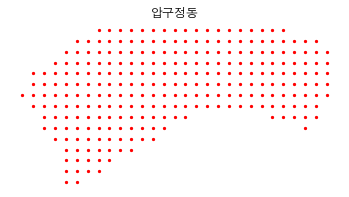

In [194]:
ax = binary['geometry'].plot(marker='o', color='red', markersize=5)
ax.set_axis_off()
ax.set_title("압구정동")
plt.show()

## distance_matrix

In [195]:
coord_list = [(x,y) for x,y in zip(binary['geometry'].x , binary['geometry'].y)]

In [196]:
x = np.asarray(binary['geometry'].x) # Replace with data
y = np.asarray(binary['geometry'].y) # Replace with data

x_i = x[:, np.newaxis]
x_j = x[np.newaxis, :]

y_i = y[:, np.newaxis]
y_j = y[np.newaxis, :]

d = (x_i-x_j)**2+(y_i-y_j)**2

distance_matrix = np.sqrt(d, out=d)

In [197]:
distance_matrix

array([[   0.        ,  100.        ,  200.        , ..., 2158.70331449,
        2184.03296678, 2213.59436212],
       [ 100.        ,    0.        ,  100.        , ..., 2137.75583264,
        2158.70331449, 2184.03296678],
       [ 200.        ,  100.        ,    0.        , ..., 2121.32034356,
        2137.75583264, 2158.70331449],
       ...,
       [2158.70331449, 2137.75583264, 2121.32034356, ...,    0.        ,
         100.        ,  200.        ],
       [2184.03296678, 2158.70331449, 2137.75583264, ...,  100.        ,
           0.        ,  100.        ],
       [2213.59436212, 2184.03296678, 2158.70331449, ...,  200.        ,
         100.        ,    0.        ]])

In [198]:
distance_matrix.shape

(264, 264)

In [199]:
binary.drop(['geometry'], axis=1, inplace=True)
binary.head()

,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,
1,0.0,0.0,0.0,1.0
2,1.0,159638.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
228,1.0,159638.0,1.0,1.0


## Feature Scaling

In [202]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(binary)
standadized_df = pd.DataFrame(normalized_data)
binary = pd.DataFrame(standadized_df.values, columns=binary.columns, index=binary.index)
binary.head()

,bs_count,bs_승하차수,ss_count,cs_count
unique_id,,,,
1,0.000000,0.000000,0.0,0.125
2,0.027778,0.182454,0.0,0.125
3,0.000000,0.000000,0.0,0.125
4,0.000000,0.000000,0.0,0.125
228,0.027778,0.182454,0.5,0.125


In [203]:
binary_label.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [204]:
binary['label'] = binary_label.values
binary

,bs_count,bs_승하차수,ss_count,cs_count,label
unique_id,,,,,
1,0.000000,0.000000,0.0,0.125,0
2,0.027778,0.182454,0.0,0.125,0
3,0.000000,0.000000,0.0,0.125,0
4,0.000000,0.000000,0.0,0.125,0
228,0.027778,0.182454,0.5,0.125,0
...,...,...,...,...,...
60510,0.000000,0.000000,0.0,0.000,0
60511,0.000000,0.000000,0.0,0.000,0
60512,0.000000,0.000000,0.0,0.000,0


## predict

In [227]:
from sklearn.model_selection import train_test_split

In [228]:
binary

,bs_count,bs_승하차수,ss_count,cs_count,label
unique_id,,,,,
1,0.000000,0.000000,0.0,0.125,0
2,0.027778,0.182454,0.0,0.125,0
3,0.000000,0.000000,0.0,0.125,0
4,0.000000,0.000000,0.0,0.125,0
228,0.027778,0.182454,0.5,0.125,0
...,...,...,...,...,...
60510,0.000000,0.000000,0.0,0.000,0
60511,0.000000,0.000000,0.0,0.000,0
60512,0.000000,0.000000,0.0,0.000,0


In [229]:
X = binary.drop(['cs_count', 'label', 'ss_count'], axis=1)
y = binary['label']

In [230]:
X

,bs_count,bs_승하차수
unique_id,,
1,0.000000,0.000000
2,0.027778,0.182454
3,0.000000,0.000000
4,0.000000,0.000000
228,0.027778,0.182454
...,...,...
60510,0.000000,0.000000
60511,0.000000,0.000000
60512,0.000000,0.000000


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
y_train

unique_id
10060    0
2320     0
2325     0
59963    0
57521    1
        ..
993      0
57527    0
1903     0
7903     0
7899     0
Name: label, Length: 211, dtype: int64

In [233]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [234]:
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[166,   9],
       [ 17,  19]])

In [235]:
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)

(0.6785714285714286, 0.5277777777777778)

In [236]:
y_score = cross_val_predict(rf, X_train, y_train, cv=3)
y_score

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [237]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)
precisions, recalls

(array([0.17061611, 0.62068966, 1.        ]), array([1. , 0.5, 0. ]))

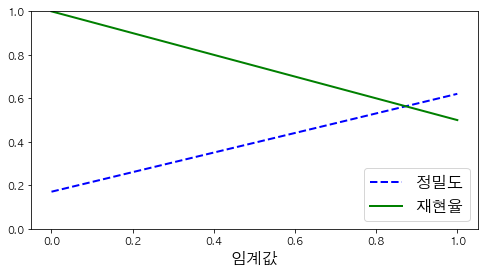

In [238]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="lower right", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [239]:
y_pred = rf.predict_proba(X_test)
y_pred

array([[0.69      , 0.31      ],
       [0.93876861, 0.06123139],
       [0.78155952, 0.21844048],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.91515873, 0.08484127],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [1.        , 0.        ],
       [0.35      , 0.65      ],
       [0.97513997, 0.02486003],
       [0.72891486, 0.27108514],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.69      , 0.31      ],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [1.        , 0.        ],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [0.93876861, 0.06123139],
       [1.        , 0.        ],
       [0.41167063, 0.58832937],
       [0.233     , 0.767     ],
       [0.

In [240]:
rf.feature_importances_

array([0.33695232, 0.66304768])

In [241]:
y_test

unique_id
1900     0
57809    1
2475     0
59743    0
8240     0
8746     1
8244     0
57017    0
453      0
59962    0
57011    1
58416    1
59960    0
2324     0
58419    0
8242     0
57810    0
57811    0
1899     0
59344    0
450      0
1101     0
1039     0
1688     0
57016    0
7898     0
992      0
9527     0
56618    1
8301     1
57012    1
8794     0
56617    1
58970    0
988      0
57741    1
59338    0
1689     0
1438     0
56557    1
2322     0
59737    0
58868    0
454      0
8747     0
10059    0
9584     1
58869    0
1040     0
57523    1
58128    0
991      0
2526     0
Name: label, dtype: int64

In [242]:
X

,bs_count,bs_승하차수
unique_id,,
1,0.000000,0.000000
2,0.027778,0.182454
3,0.000000,0.000000
4,0.000000,0.000000
228,0.027778,0.182454
...,...,...
60510,0.000000,0.000000
60511,0.000000,0.000000
60512,0.000000,0.000000


In [243]:
weight = rf.predict_proba(X)

In [244]:
weight[:,0]

array([0.93876861, 0.93      , 0.93876861, 0.93876861, 0.93      ,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 1.        , 1.        , 1.        , 1.        ,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 1.        ,
       0.93876861, 0.02      , 0.56      , 0.56      , 0.99      ,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       1.        , 1.        , 1.        , 1.        , 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.93876861, 0.93876861, 0.93876861,
       0.93876861, 0.93876861, 0.69      , 0.69      , 1.        ,
       1.        , 0.93876861, 0.05      , 0.93876861, 0.93876

In [245]:
y.index

Int64Index([    1,     2,     3,     4,   228,   449,   450,   451,   452,
              453,
            ...
            59965, 59966, 60507, 60508, 60509, 60510, 60511, 60512, 60513,
            60514],
           dtype='int64', name='unique_id', length=264)

In [246]:
final_df = pd.DataFrame(y, index=y.index)
final_df['weight'] = weight[:,0]

In [247]:
final_df

,label,weight
unique_id,,
1,0,0.938769
2,0,0.930000
3,0,0.938769
4,0,0.938769
228,0,0.930000
...,...,...
60510,0,0.938769
60511,0,0.938769
60512,0,0.938769


# MCLP

In [249]:
distance_matrix

array([[   0.        ,  100.        ,  200.        , ..., 2158.70331449,
        2184.03296678, 2213.59436212],
       [ 100.        ,    0.        ,  100.        , ..., 2137.75583264,
        2158.70331449, 2184.03296678],
       [ 200.        ,  100.        ,    0.        , ..., 2121.32034356,
        2137.75583264, 2158.70331449],
       ...,
       [2158.70331449, 2137.75583264, 2121.32034356, ...,    0.        ,
         100.        ,  200.        ],
       [2184.03296678, 2158.70331449, 2137.75583264, ...,  100.        ,
           0.        ,  100.        ],
       [2213.59436212, 2184.03296678, 2158.70331449, ...,  200.        ,
         100.        ,    0.        ]])

In [250]:
final_model_df = final_df.reset_index()
final_save = final_model_df.copy()
final_model_df

,unique_id,label,weight
0,1,0,0.938769
1,2,0,0.930000
2,3,0,0.938769
3,4,0,0.938769
4,228,0,0.930000
...,...,...,...
259,60510,0,0.938769
260,60511,0,0.938769
261,60512,0,0.938769
262,60513,0,0.938769


In [251]:
from pulp import *

# Data
I = final_model_df.index # 수요 포인트
J = final_model_df.index # 후보 포인트
S = 500 # 커버리지
d = distance_matrix

w = final_model_df['weight'] # 가중치
K = 10


# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node
N = [[j for j in J if d[i][j] < S] for i in I]

# Formulation
prob = LpProblem("MCLP", LpMaximize)

# Variable
x = LpVariable.dicts("x", J, 0, cat='Binary')
y = LpVariable.dicts("y", I, 0, cat='Binary')

# Objective
prob += lpSum([w[i]*y[i] for i in I])

# Constraints
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == K

# Solve problem
prob.solve()

x_soln = np.array([x[j].varValue for j in J])
y_soln = np.array([y[i].varValue for i in I])

# Print output
print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("x = ", x_soln)
print ("y = ", y_soln)


Status: Optimal
Population Served is =  218.80955034008204
x =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [252]:
final_model_df = final_model_df.set_index('unique_id')
final_model_df

,label,weight
unique_id,,
1,0,0.938769
2,0,0.930000
3,0,0.938769
4,0,0.938769
228,0,0.930000
...,...,...
60510,0,0.938769
60511,0,0.938769
60512,0,0.938769


In [253]:
len(x)

264

In [254]:
final_model_df['optimal'] = x_soln
final_model_df['polygon'] = sa['geometry']
final_model_df = gpd.GeoDataFrame(final_model_df)
final_model_df

,label,weight,optimal,polygon
unique_id,,,,
1,0,0.938769,0.0,"POLYGON ((957035.230 1947987.158, 957135.230 1..."
2,0,0.930000,0.0,"POLYGON ((957035.230 1948087.158, 957135.230 1..."
3,0,0.938769,0.0,"POLYGON ((957035.230 1948187.158, 957135.230 1..."
4,0,0.938769,0.0,"POLYGON ((957035.230 1948287.158, 957135.230 1..."
228,0,0.930000,0.0,"POLYGON ((956935.230 1948087.158, 957035.230 1..."
...,...,...,...,...
60510,0,0.938769,0.0,"POLYGON ((959135.230 1948287.158, 959235.230 1..."
60511,0,0.938769,0.0,"POLYGON ((959135.230 1948387.158, 959235.230 1..."
60512,0,0.938769,0.0,"POLYGON ((959135.230 1948487.158, 959235.230 1..."


In [255]:
demand_point = gpd.GeoDataFrame(final_model_df[final_model_df['optimal']==1])
demand_point

,label,weight,optimal,polygon
unique_id,,,,
454,0,0.938769,1.0,"POLYGON ((957135.230 1948287.158, 957235.230 1..."
986,0,1.000000,1.0,"POLYGON ((957335.230 1947487.158, 957435.230 1..."
7903,0,0.938769,1.0,"POLYGON ((959335.230 1948687.158, 959435.230 1..."
8746,1,0.915159,1.0,"POLYGON ((959535.230 1947987.158, 959635.230 1..."
56559,0,0.938769,1.0,"POLYGON ((958035.230 1948287.158, 958135.230 1..."
56561,0,0.938769,1.0,"POLYGON ((958035.230 1948487.158, 958135.230 1..."
56948,0,0.938769,1.0,"POLYGON ((957935.230 1947887.158, 958035.230 1..."
56953,0,0.938769,1.0,"POLYGON ((957935.230 1948387.158, 958035.230 1..."
57520,1,0.040000,1.0,"POLYGON ((958335.230 1947987.158, 958435.230 1..."


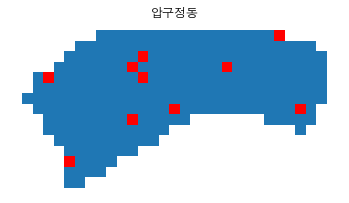

In [256]:
base = final_model_df['polygon'].plot()
ax = demand_point['polygon'].plot(ax=base, color='red')
ax.set_axis_off()
ax.set_title("압구정동")
plt.show()